In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms as transforms
from torchvision.datasets import CIFAR10
import torch.nn as nn
from pytorch_lightning.callbacks import Callback
import torch.optim as optim
import sys
import pytorch_lightning as pl
import os



In [26]:
#adjustable hparams
batch_size = 64
lr = 1e-3
max_epochs = 120
latent_dim = 128
#change this to 'cuda'
device = 'cpu'


dataset_path = '/Users/gpnuser/Documents/Horos Data/Jas_Pycharm/VAE'
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, profile=None, sci_mode=False)
np.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=None, suppress=True, nanstr=None, infstr=None, formatter=None, sign=None, floatmode=None, legacy=None)

In [27]:

stride = 2
padding = 1
kernel_size = 3
#dont touch this stuff
# Transformations applied on each image => only make them a tensor
#transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
transform = transforms.ToTensor()
# Loading the training dataset. We need to split it into a training and validation part
train_dataset = CIFAR10(root=dataset_path, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [45000, 5000])

# Loading the test set
test_set = CIFAR10(root=dataset_path, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, drop_last=False, num_workers=4)


def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)


Files already downloaded and verified


Global seed set to 42


Files already downloaded and verified


In [51]:
# layer architecture
class Autoencoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=stride, padding=padding),            # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=stride, padding=padding),           # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=stride, padding=padding),           # [batch, 48, 4, 4]
            nn.ReLU(),
# 			nn.Conv2d(48, 96, 4, stride=stride, padding=padding),           # [batch, 96, 2, 2]
#             nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=stride, padding=padding),  # [batch, 48, 4, 4]
#             nn.ReLU(),
			nn.ConvTranspose2d(48, 24, 4, stride=stride, padding=padding),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=stride, padding=padding),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=stride, padding=padding),   # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )
    def forward(self, x):
        latent = self.encoder(x)
        reconstructed = self.decoder(latent)
  #      plt.imshow(reconstructed[0].detach().numpy().permute(1,2,0))
        return latent, reconstructed

    def get_loss(self, batch):
        x, _ = batch  # We do not need the labels
        latent, reconstructed = self.forward(x)
        loss = nn.functional.mse_loss(x, reconstructed)
        loss = torch.mean(loss)
        if debug:
            print('loss is:')
            print(loss)
        return loss

    def training_step(self, batch, batch_idx):
        loss = self.get_loss(batch)

        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.get_loss(batch)
        #implement log loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def represent(self):
        print('encoder is:')
        print(self.encoder)
        print('decoder is:')
        print(self.decoder)

net = Autoencoder()


In [52]:
if __name__ == "__main__":
    net.represent()
    trainer = pl.Trainer(max_epochs=max_epochs)
    trainer.fit(net, train_loader, val_loader)

encoder is:
Sequential(
  (0): Conv2d(3, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
)
decoder is:
Sequential(
  (0): ConvTranspose2d(48, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): ConvTranspose2d(24, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(12, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): Sigmoid()
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 23.7 K
1 | decoder | Sequential | 23.7 K
---------------------------------------
47.4 K    Trainable params
0         Non-trainable params
47.4 K    Total params
0.189     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Fatal Python error: init_import_site: /Users/gpnuser/Documents/Horos Data/Jas_Pycharm/PycharmProject/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Failed to import the site module
Python runtime state: initialized
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site.py", line 589, in <module>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc4fd1df160>
Traceback (most recent call last):
  File "/Users/gpnuser/Documents/Horos Data/Jas_Pycharm/PycharmProject/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/Users/gpnuser/Documents/Horos Data/Jas_Pycharm/PycharmProject/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1424, in _shutdown_workers
  

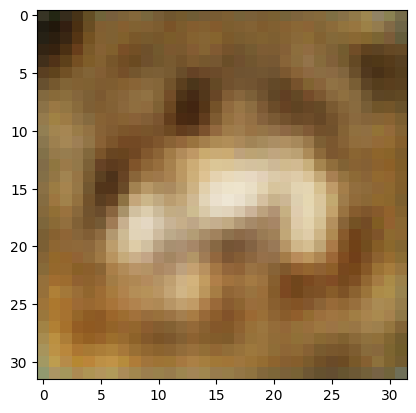

In [54]:
net.eval()
model_path = '/Users/gpnuser/PycharmProjects/pythonProject/Cifar_VAE/lightning_logs/version_10/checkpoints/epoch=11-step=2100.ckpt'
saved_model = Autoencoder.load_from_checkpoint(model_path)
x = get_train_images(1)
with torch.no_grad():
    debug=1
    out_data = saved_model(x)[1].squeeze()
    debug=0
plt.imshow(out_data.permute(1,2,0))